In [1]:
from osgeo import gdal
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os
from rasterio.features import shapes

from dem_utils_import import plot_rast, load_rast

C:\Users\montse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
#We Open the classified raster that we want to work with: 
class_raster_path = './notebook_outputs/rasters/classified_raster.tif'
classified_raster = load_rast.open_raster_array(class_raster_path)

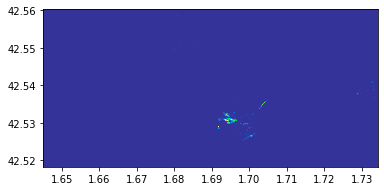

In [3]:
#Verification that the raster has proper areas of terrain:
plot_rast.quick_show_rasterio(class_raster_path)

In [4]:
#Polygonization of the input raster:
mask = None

with rasterio.Env():
    with rasterio.open(class_raster_path) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))

geoms = list(results)
polygonized_raster  = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')

In [5]:
#We want to take only the polygons whoch rastser_val = 1 (raster_val = 0. => polygons containing points out of bounds):
polygonized_raster = polygonized_raster.loc[polygonized_raster.raster_val != 0.]
output_path_polygonized_raster = './notebook_outputs/rasters/polygons.geojson'
#polygonized_raster.to_file(output_path_polygonized_raster)

In [6]:
#Load the snow depth geodataframe
snow_depth_path = 'C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/kram_files/inputs/snow_depth_data/grau_roig/sd_210322.geojson'
snow_file_gdf = gpd.read_file(snow_depth_path)
snow_file_gdf = snow_file_gdf.set_crs('epsg:4326')

In [7]:
#Spatial join btw the points and polygons:
sorted_points = gpd.sjoin(snow_file_gdf, polygonized_raster, how='inner', predicate='within')
sorted_points.reset_index(inplace=True)
sorted_points.drop(columns=['index', 'lon', 'lat', 'raster_val'], inplace=True)
sorted_points.rename(columns={'index_right': 'polygon_nb'}, inplace=True)

In [8]:
sorted_points

,snow_depth,sector,trail_code,geometry,polygon_nb
0,0.959386,grau,debutants,POINT (1.69915 42.53231),1135
1,0.731219,grau,debutants,POINT (1.69955 42.53237),1105
2,0.742872,grau,debutants,POINT (1.69969 42.53204),1292
3,0.452857,grau,debutants,POINT (1.69969 42.53205),1292
4,0.025178,grau,debutants,POINT (1.69969 42.53206),1292
...,...,...,...,...,...
704,1.441016,grau,pastora,POINT (1.70482 42.53611),735
705,1.807227,pas,directa,POINT (1.73119 42.53828),602
706,1.894945,pas,directa,POINT (1.73121 42.53826),604
707,2.101296,pas,directa,POINT (1.73122 42.53826),604


In [9]:
#Statistical operation:
mean_snow_depth = sorted_points.groupby('polygon_nb')['snow_depth'].mean()
mean_snow_depth.mean()

0.8837228012141325

## Map Check:

<AxesSubplot:>

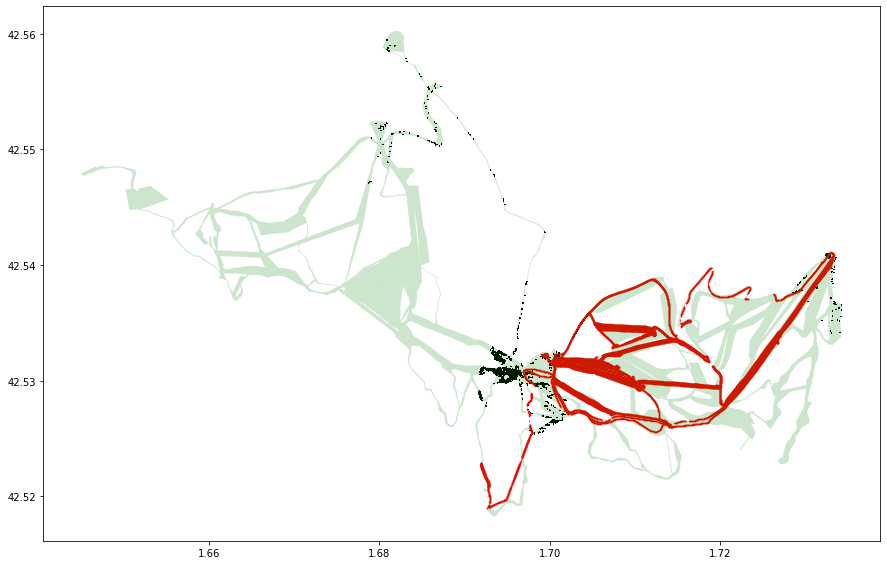

In [10]:
#Checking that the polygonized raster overlaps the original trails file:
trails = gpd.read_file('./notebook_outputs/shapefile/trails_2d_shapefile.shp')

base = polygonized_raster.plot(color='white', edgecolor='black', alpha=1., figsize=(15,15))
snow_file_gdf.plot(ax = base, marker='.', color='red', markersize=0.2, alpha=0.3)
trails.plot(ax=base, marker='.', color='green', alpha=0.2)

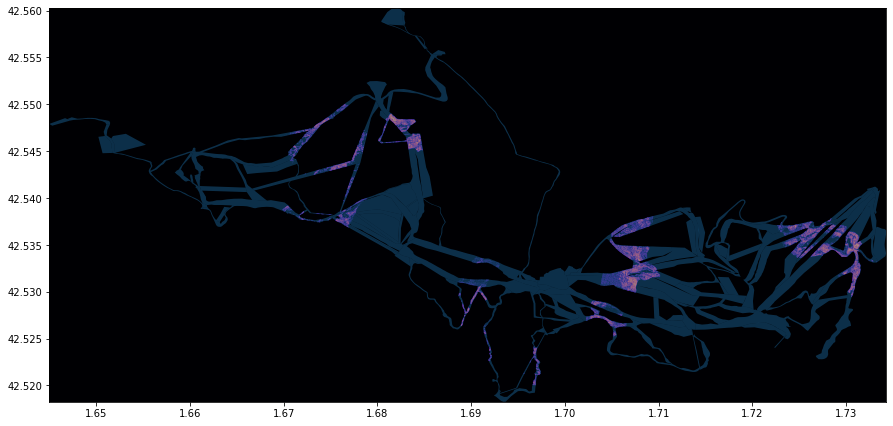

In [11]:
#trails_path = './outputs/geojson/trails_2d.shp'
rast = rasterio.open('C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/kram_files/outputs/rasters/classified_rasters/2100_2200_15_20_north.tif')
rast2 = rasterio.open('C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/kram_files/outputs/rasters/classified_rasters/2200_2300_10_15_north.tif')
#trails = gpd.read_file(trails)

f, ax = plt.subplots(figsize=(15,15))
trails.plot(ax=ax, alpha=0.4)
rasterio.plot.show(rast, ax=ax, cmap='magma')
rasterio.plot.show(rast2, ax=ax, cmap='magma') #with_bounds = True, ax=ax, cmap='magma')
plt.show()